### Udacity Self Driving Car Nanodegree: Term1: Project  4: Advanced Lane Lines Detection
March 2018
David Escolme

In [1]:
# imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import random
%matplotlib inline

In [2]:
# globals for test mode change this to false to avoid test images being generated
TEST_MODE = True

# globals for calibration inside corners
NX = 9
NY = 6

# calibration images
IMG_DIR = 'camera_cal/'
calibration_files = glob.glob(IMG_DIR+"*.jpg")

# test images
TST_DIR = 'test_images/'
test_files = glob.glob(TST_DIR+"*.jpg")

#### Calibration Section

In [3]:
def calibrate_camera(calibration_files, nx, ny):
    """ 
        function to calibrate a camera given a list of images 
        
        Args: 
            calibration_files: a list of locations of images
            nx, ny: the number of inside corners on the images
            
        Returns: img and obj points for use in undistortion
    """
    # create the empty return lists
    objpoints = []
    imgpoints = []
    
    # setup the object point array
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # now iterate the file list, open each image, convert to gray and find the corners
    for img in calibration_files:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # if corners found, then add them to output 
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return (objpoints, imgpoints)

if TEST_MODE: testobj, testimg = calibrate_camera(calibration_files, NX, NY)

#### Undistortion

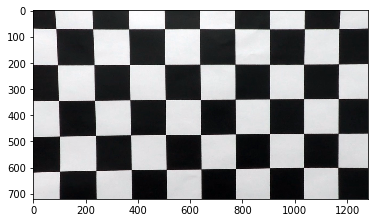

In [4]:
def img_undistort(img, objpoints, imgpoints):
    """ 
        function to undistort an image
        Args:
            img: the image to process
            objpoints, imgpoints: the calibration coeffs
        Returns:
            undistort: the undistorted image
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

if TEST_MODE: 
    img_undistorted = img_undistort(cv2.imread(calibration_files[0]), testobj, testimg)
    plt.imshow(img_undistorted)
    plt.show()

#### Thresholding

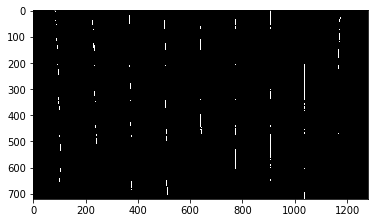

In [5]:
def sobel_thresh_abs(img, orient='x', thresh=(50,100)):
    """
        function to return a sobel absolute threshold
        Args: 
            img: the undistorted image to threshold
            orient: whether to apply x or y axis
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # get grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # do sobel
    if orient == 'x':
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # abssolute value
    abs_sobelv = np.absolute(sobelv)
    scaled_sobelv = np.uint8(255*abs_sobelv/np.max(abs_sobelv))
    # now threshold
    sbinary = np.zeros_like(scaled_sobelv)
    sbinary[(scaled_sobelv >= thresh[0]) & (scaled_sobelv <= thresh[1])] = 1
    return sbinary

if TEST_MODE:
    plt.imshow(sobel_thresh_abs(img_undistorted, 'x', (50,100)), cmap='gray')
    plt.show()

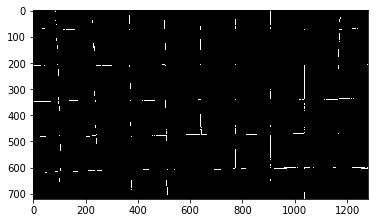

In [6]:
def sobel_thresh_mag(img, sobel_kernel=3, thresh=(0, 255)):
    """
        function to return a sobel magnitude threshold
        Args: 
            img: the undistorted image to threshold
            sobel_kernel: the kernel value (odd number)
            thresh: the min and max threshold values
        Returns:
            sxybinary: a thresholded binary image
        
    """
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sxybinary

if TEST_MODE:
    plt.imshow(sobel_thresh_mag(img_undistorted, 7, (50,100)), cmap='gray')
    plt.show()

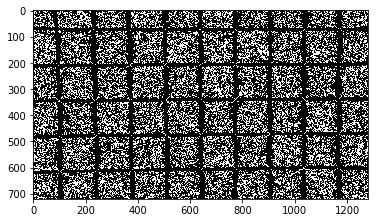

In [7]:
def sobel_thresh_dir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
        function to return a sobel direction threshold
        Args: 
            img: the undistorted image to threshold
            sobel_kernel: the kernel value (odd number)
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sbinary

if TEST_MODE:
    plt.imshow(sobel_thresh_dir(img_undistorted, 15, (0.7,1.3)), cmap='gray')
    plt.show()

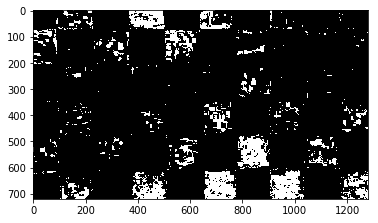

In [8]:
def hls_select(img, thresh=(0, 255)):
    """
        function to return a hls color threshold
        Args: 
            img: the undistorted image to threshold
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # apply a threshold to the S channel
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # return a binary image of threshold result
    return sbinary

if TEST_MODE:
    plt.imshow(hls_select(img_undistorted, (40,190)), cmap='gray')
    plt.show()

#### perspective transform

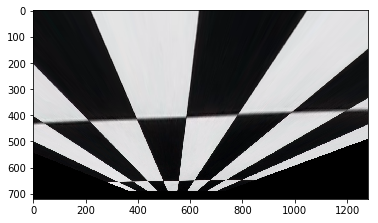

In [9]:
def apply_perspective_transform_1(img, src=None, dst=None):
    """
        function to apply a perspective transform
        Args: 
            img: the undistorted image to threshold
            src, dst: corners to transform from / to tr,br,bl,tl
        Returns:
            an image transformed to new coordinates        
    """
    # get image size
    img_size = (img.shape[1], img.shape[0])
    
    # coordinate defaults (might not always work...)
    if not src: src = np.float32([[675,450],[1100,680],[325,680],[575,450]])
    if not dst: dst = np.float32([[700,150],[700,680],[450,680],[450,150]])
    
    # get transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

if TEST_MODE:
    plt.imshow(apply_perspective_transform_1(img_undistorted), cmap='gray')
    plt.show()

### Showing the results of image transformation for the test set

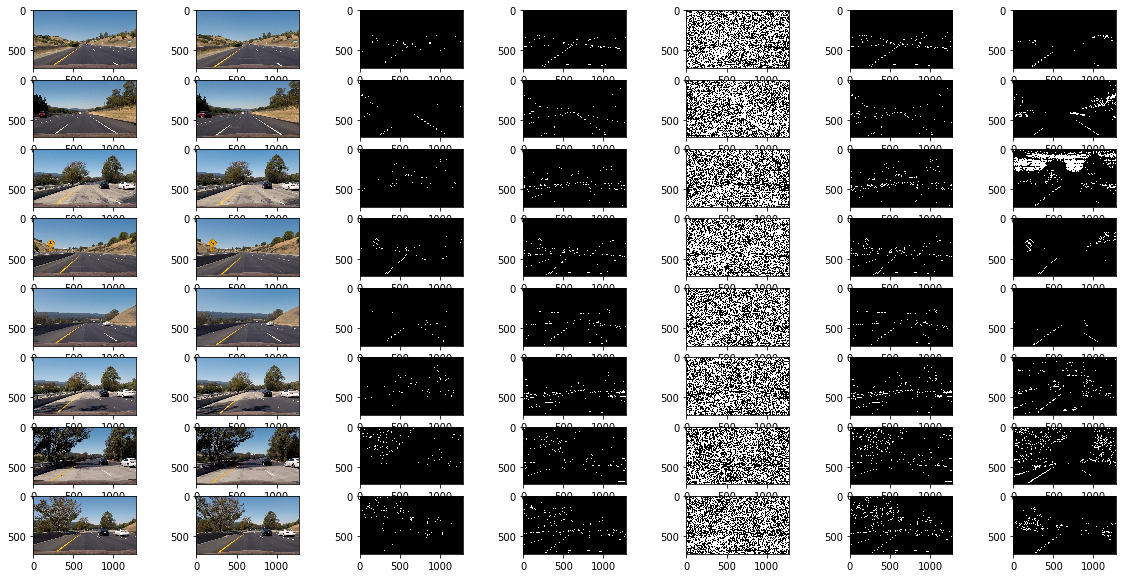

In [10]:
def print_image(img, fig, i, cmap=None):
    fig.add_subplot(8, 7, i)
    plt.imshow(img, cmap)
    i += 1
    return i

def process_images(test_files, testobj=None, testimg=None):
    """
        function to process the test image set
        prints the results
        Args:
            test_files: the list of files to process
            testobj, testimg: the camera calibration coeffs
    """
    fig=plt.figure(figsize=(20, 10))
    # iterate test_files and create a list of images
    i = 1
    for file in test_files:
        img = cv2.imread(file)
        undistort = img_undistort(img, testobj, testimg)
        sobel_x = sobel_thresh_abs(undistort, 'x', (60, 120))
        sobel_y = sobel_thresh_abs(undistort, 'y', (60, 120))
        sobel_dir = sobel_thresh_dir(undistort, 15, (0.6,1.4))
        sobel_mag = sobel_thresh_mag(undistort, 15, (60,120))
        color_select = hls_select(undistort, (125,240))
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, i)
        i = print_image(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB), fig, i)
        i = print_image(sobel_x, fig, i, 'gray')
        i = print_image(sobel_y, fig, i, 'gray')
        i = print_image(sobel_dir, fig, i, 'gray')
        i = print_image(sobel_mag, fig, i, 'gray')
        i = print_image(color_select, fig, i, 'gray')
        
    plt.show()
    
if TEST_MODE:
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    process_images(test_files, testobj, testimg)

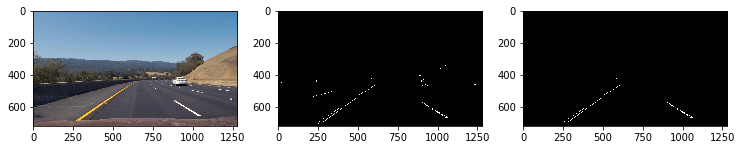

In [11]:
def apply_region_of_interest(img, vertices=None, output_type=None):
    """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        vertices can be controlled by passing a region array to the lane detector
        before calling Process_Image()
        Args:
            img: the image to mask can be binary or color
            vertices: the area to apply the mask to
        Returns:
            a masked image
    """
    # setup default vertices if none passed
    if not vertices:
        vertices = np.array([[(800,400),(1200, 700), (200, 700), (500, 400)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    # now scale to 0,1
    masked_binary = np.zeros_like(masked_image)
    masked_binary[(masked_image > 0)] = 1
    
    return masked_binary

if TEST_MODE:
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    undistorted = img_undistort(img, testobj, testimg)
    color_select = hls_select(undistorted, (125, 200))
    masked = apply_region_of_interest(color_select)
    fig=plt.figure(figsize=(30, 20))
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, 1)
    print_image(color_select, fig, 2, cmap='gray')
    print_image(masked, fig, 3, cmap='gray')
    plt.show()

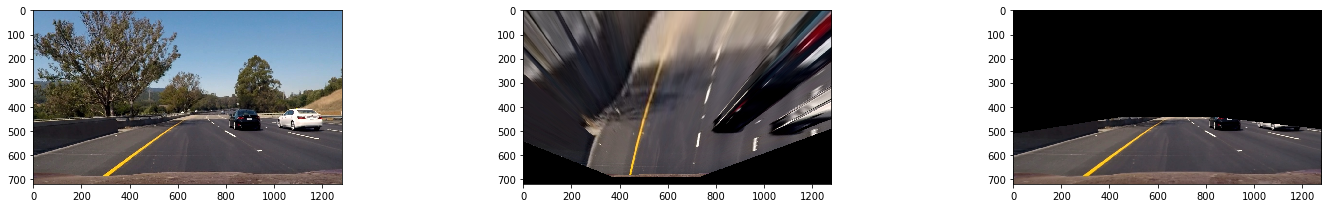

In [12]:
def apply_perspective_transform(img, reverse=False, src=None, dst=None):
    """
        function to apply a perspective transform or invert it
        can't remember why this has been defined twice...
        Args: 
            img: the undistorted image to threshold
            reverse: whether to invert or not
            src, dst: corners to transform from / to tr,br,bl,tl
        Returns:
            an image transformed to new coordinates
    """
    # get image size
    img_size = (img.shape[1], img.shape[0])
    
    # coordinates
    src = np.float32([[675,450],[1100,680],[325,680],[575,450]])
    dst = np.float32([[700,150],[700,680],[450,680],[450,150]])
    
    # get transform
    if not reverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

if TEST_MODE:
    # choose random test image
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    img_a = apply_perspective_transform(img)
    img_b = apply_perspective_transform(img_a, reverse=True)
    fig=plt.figure(figsize=(60, 30))
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, 1)
    print_image(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB), fig, 2)
    print_image(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB), fig, 3)

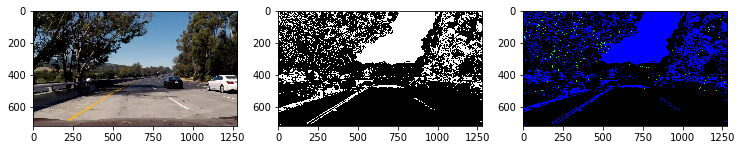

In [13]:
def get_combined(img, ksize=7, sobel_thresh=(50, 100), direction_thresh=(0.7, 1.3), color_thresh=(40, 190)):
    undistorted = img_undistort(img, testobj, testimg)
    gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[0], sobel_thresh[1]))
    grady = sobel_thresh_abs(undistorted, 'y', thresh=(sobel_thresh[0], sobel_thresh[1]))
    mag_binary = sobel_thresh_mag(undistorted, ksize, thresh=(sobel_thresh[0], sobel_thresh[1]))
    dir_binary = sobel_thresh_dir(undistorted, ksize, thresh=(direction_thresh[0], direction_thresh[1]))
    color_select = hls_select(undistorted, (color_thresh[0], color_thresh[1]))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    combined_binary = np.zeros_like(combined)
    combined_binary[(combined == 1) | (color_select == 1)] = 1

    return combined_binary

def get_color_combined(img, ksize=7, sobel_thresh=(50, 100), direction_thresh=(0.7, 1.3), color_thresh=(40, 190)):
    undistorted = img_undistort(img, testobj, testimg)
    gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[0], sobel_thresh[1]))
    color_select = hls_select(undistorted, (color_thresh[0], color_thresh[1]))

    color_binary = np.dstack(( np.zeros_like(gradx), gradx, color_select)) * 255
    
    return color_binary

if TEST_MODE:
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    ksize = 15 
    combined_binary = get_combined(img, ksize, sobel_thresh=(75, 100), direction_thresh=(0.8, 1.3), color_thresh=(75, 190))
    color_binary = get_color_combined(img, ksize, sobel_thresh=(75, 100), direction_thresh=(0.8, 1.3), color_thresh=(75, 190))
    fig=plt.figure(figsize=(30, 20))
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, 1)
    print_image(combined_binary, fig, 2, cmap='gray')
    print_image(color_binary, fig, 3, None)
    plt.show()

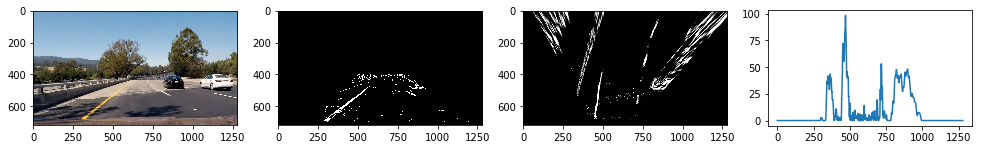

In [14]:
def return_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

if TEST_MODE:
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    ksize = 15 
    cbinary = get_combined(img, ksize, sobel_thresh=(25, 110), direction_thresh=(0.7, 1.3), color_thresh=(180, 255))
    masked = apply_region_of_interest(cbinary)
    transformed = apply_perspective_transform(masked)
    histogram = return_histogram(transformed)
    fig=plt.figure(figsize=(30, 20))
    # iterate test_files and create a list of images
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, 1)
    print_image(masked, fig, 2, cmap='gray')
    print_image(transformed, fig, 3, cmap='gray')
    fig.add_subplot(8, 7, 4)
    plt.plot(histogram)

### Experimentation with thresholds and regions of interest

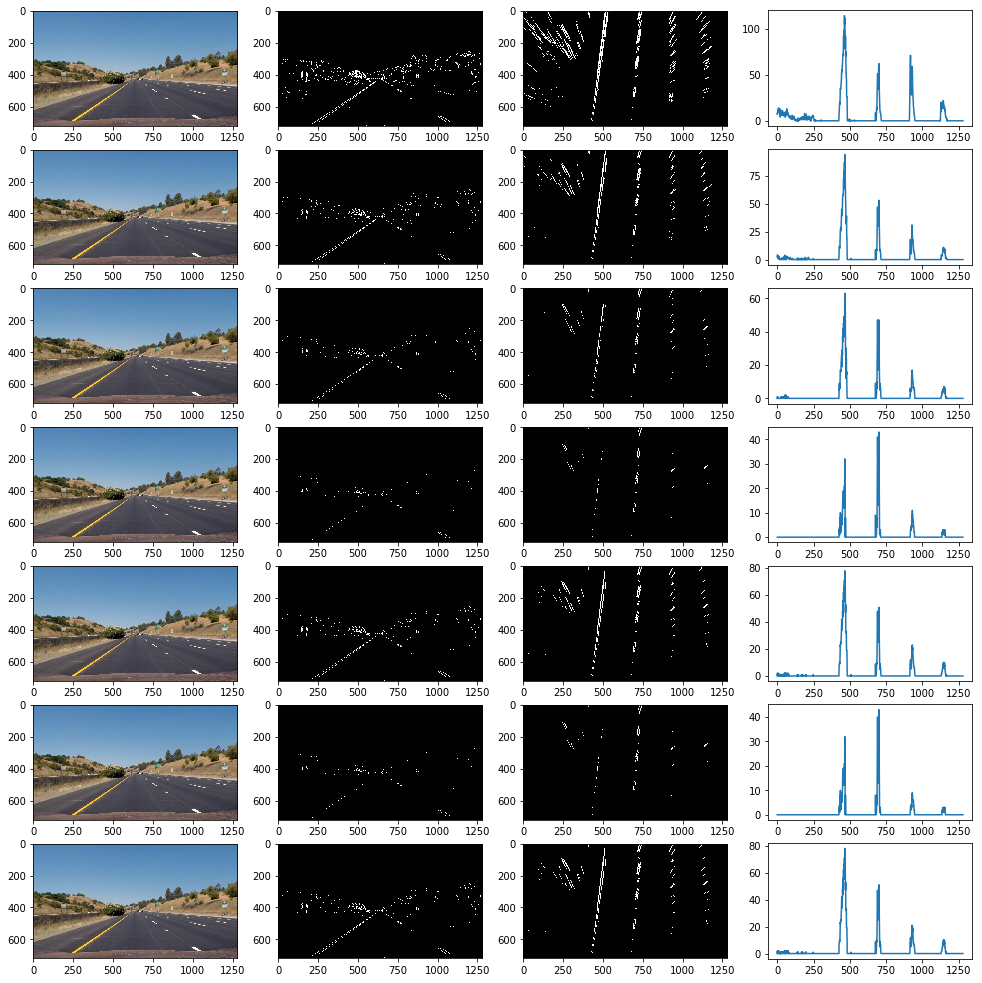

In [27]:
# individual selections - with histograms
# there are 5 thresholds, try each with 7 threshold combinations
img = cv2.imread(test_files[random.randrange(len(test_files))])
undistorted = img_undistort(img, testobj, testimg)
ksize = [3,7,9,11,13,15,21]
sobel_thresh = [
    [30,225],
    [45,135],
    [60,155],
    [75,175],
    [50,200],
    [75,150],
    [50,150]
]
# gradx
fig=plt.figure(figsize=(30, 20))
for x in range(7):
    i = (x*7)+1
    gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
    transformed = apply_perspective_transform(gradx)
    histogram = return_histogram(transformed)
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, i)
    print_image(gradx, fig, i+1, cmap='gray')
    print_image(transformed, fig, i+2, cmap='gray')
    fig.add_subplot(8, 7, i+3)
    plt.plot(histogram)

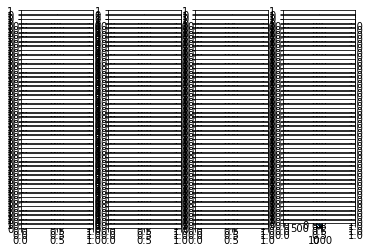

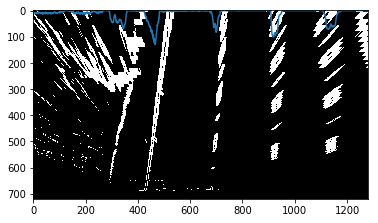

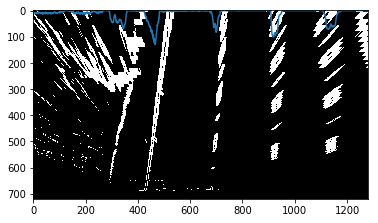

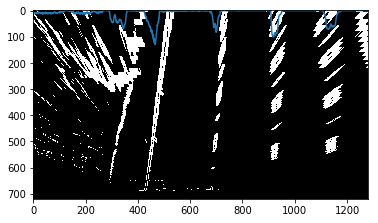

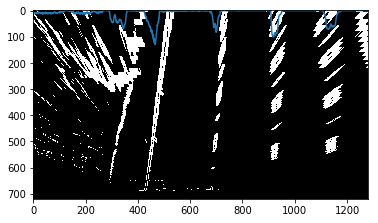

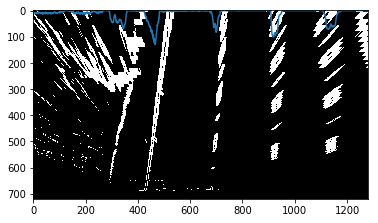

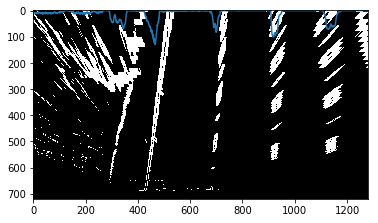

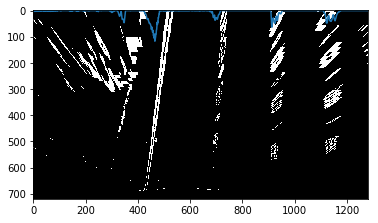

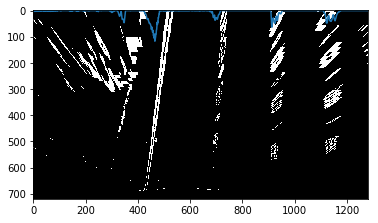

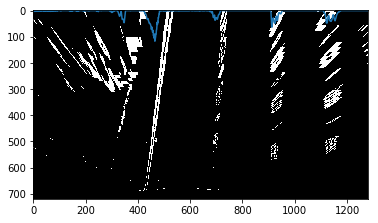

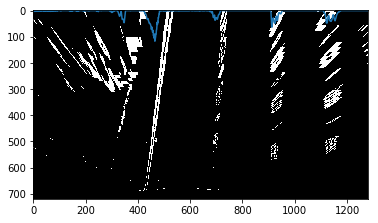

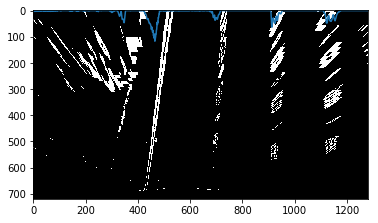

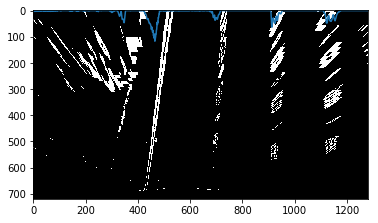

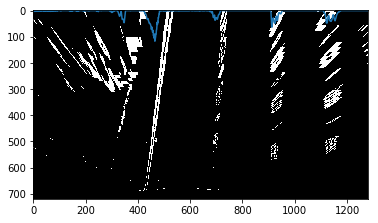

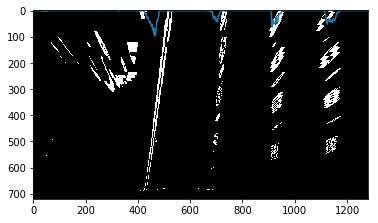

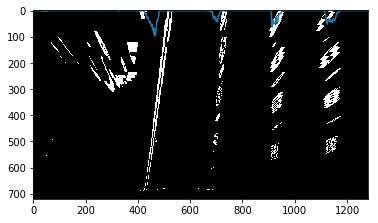

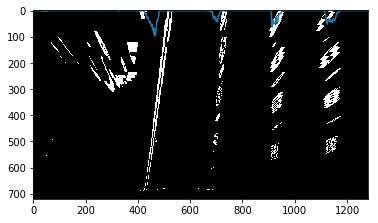

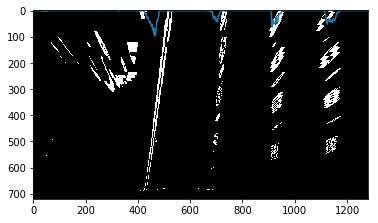

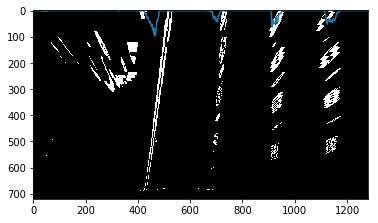

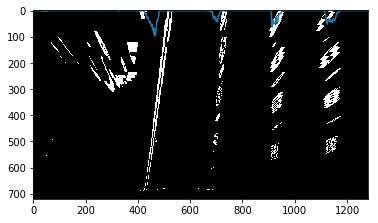

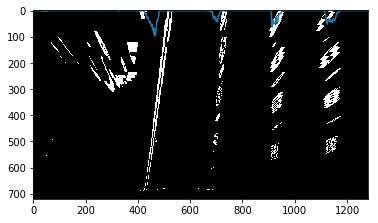

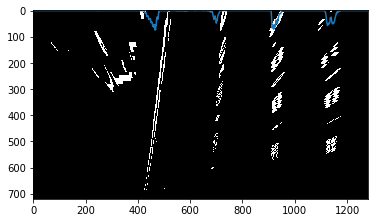

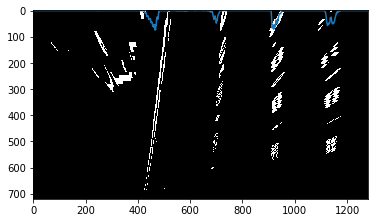

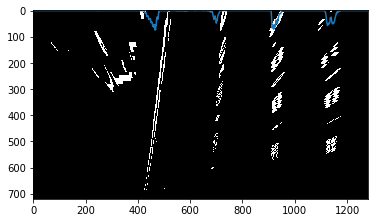

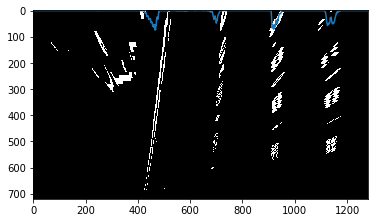

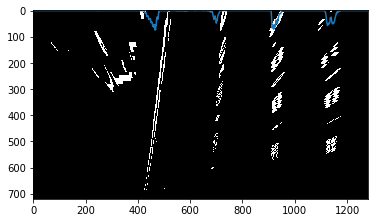

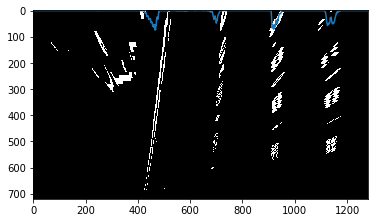

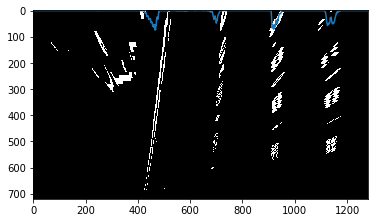

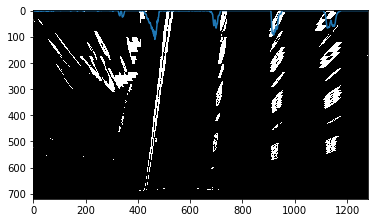

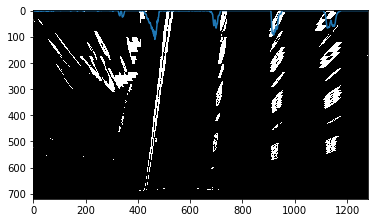

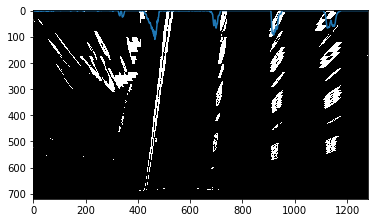

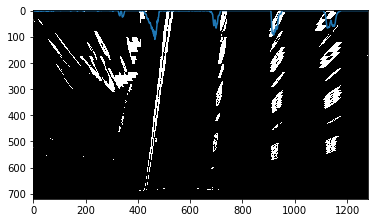

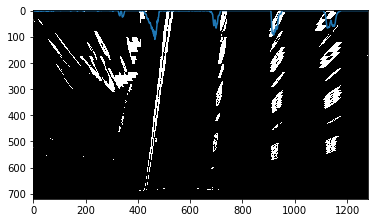

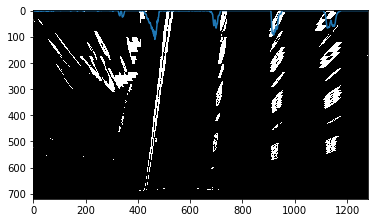

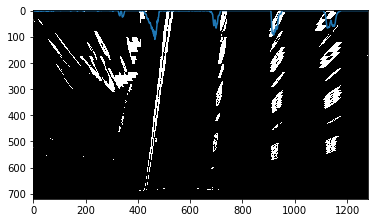

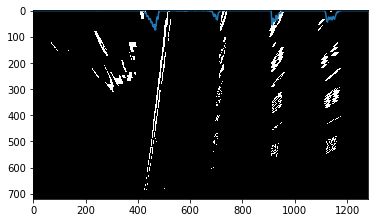

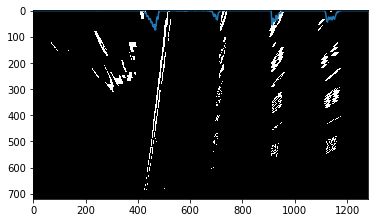

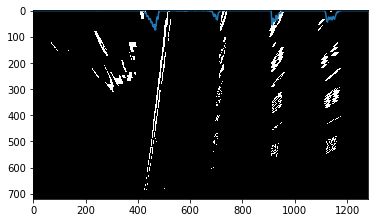

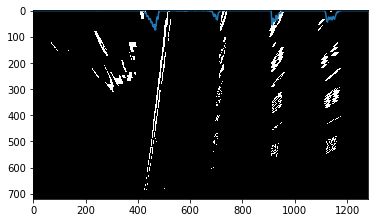

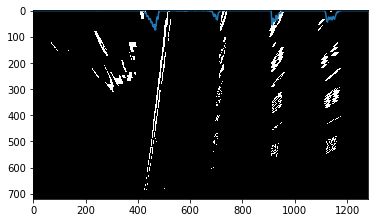

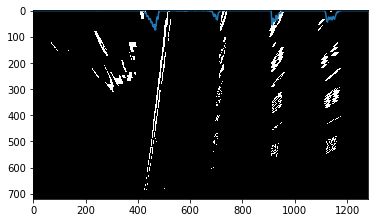

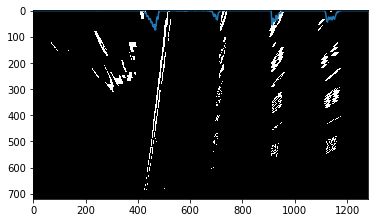

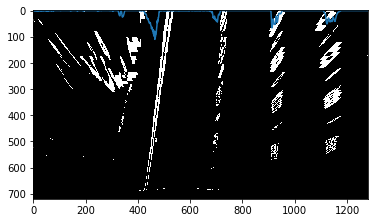

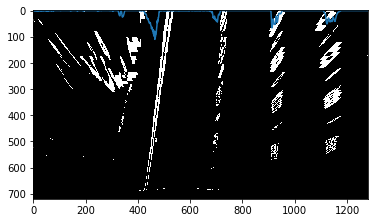

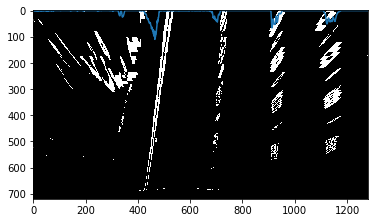

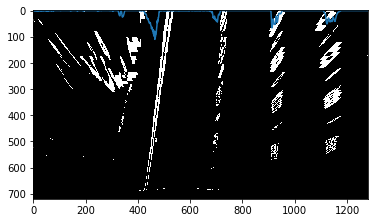

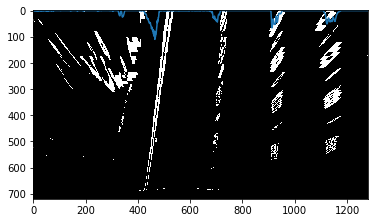

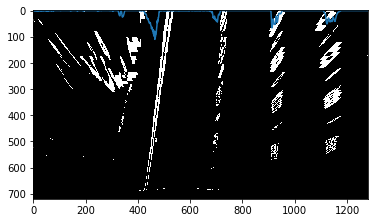

IndexError: index 49 is out of bounds for axis 0 with size 49

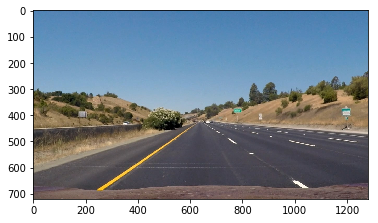

In [31]:
# sobel mag
fig, ax =plt.subplots(49, 4)
for x in range(7):
    r = (x*7)+1
    for y in range(7):
        i = r + y
        gradx = sobel_thresh_mag(undistorted, ksize[y], thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
        transformed = apply_perspective_transform(gradx)
        histogram = return_histogram(transformed)
        ax[i, 0] = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i, 1] = plt.imshow(gradx, cmap='gray')
        ax[i, 2] = plt.imshow(transformed, cmap='gray')
        ax[i, 3] = plt.plot(histogram)
        plt.show()
# combinations - with histograms
# combinations - with roi

In [43]:
def seek_lanes(img, histogram):
    """
        function to find lane lines from zero starting position
        Args:
            img: the binary thresholded and perspective transformed image
            histogram: the histogram of the lower half of the image
        Returns:
            left_fitx, right_fitx:
            ploty:
            leftcurve, rightcurve:
    """
    
    # create 3 channel version of binary image
    out_img = np.dstack((img, img, img))*255

    # find peaks
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = int(leftx_base)
    rightx_current = int(rightx_base)
    if TEST_MODE:
        print(leftx_current, rightx_current)
        print(img.shape, out_img.shape)
        print(nonzeroy.shape, nonzerox.shape)

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        if TEST_MODE:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    def fit_lines():
        """
            function to fit left and right lane lines to img
            Returns:
                left_fitx, right_fitx: fit lines
        """
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        if TEST_MODE:
            print(left_curverad, right_curverad)
            
        return left_fitx, right_fitx, ploty, left_curverad, right_curverad
    
    def print_lines():
        """
            function to draw lane lines onto image
        """
        if TEST_MODE:
            print(out_img.shape)
            print(left_lane_inds.shape)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='red')
        plt.plot(right_fitx, ploty, color='red')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    left_fitx, right_fitx, ploty, leftcurve, rightcurve = fit_lines()
    
    if TEST_MODE:
        print_lines()
    
    return left_fitx, right_fitx, ploty, leftcurve, rightcurve

433 699
(720, 1280) (720, 1280, 3)
(180356,) (180356,)
551.422824046 173.842463766
(720, 1280, 3)
(60620,)


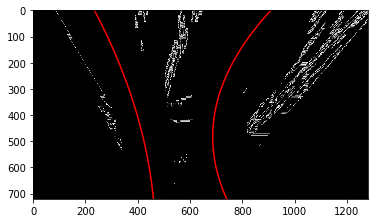

In [53]:
TEST_MODE = True
if TEST_MODE:
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    ksize = 15 
    cbinary = get_combined(img, ksize, sobel_thresh=(25, 110), direction_thresh=(0.7, 1.3), color_thresh=(80, 255))
    masked = apply_region_of_interest(cbinary)
    transformed = apply_perspective_transform(masked)
    histogram = return_histogram(transformed)
    left_fitx, right_fitx, ploty, left_curve, right_curve = seek_lanes(transformed, histogram)

461 926
(720, 1280) (720, 1280, 3)
(150229,) (150229,)
498.869904926 458.73191052
(720, 1280, 3)
(65191,)


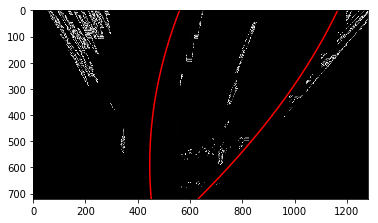

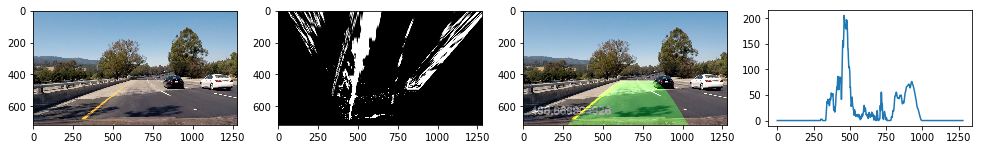

In [55]:
def draw_output(img, warped, left_fitx, rightfitx, ploty, left_curve, right_curve):
    """
        function to draw lines onto original image
        Args:
            img: original image
            warped: the warped image used for lane detection
            left_fitx, right_fitx: the fitted lines
            ploty: the linspace
        Returns:
            a final image
    """
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = apply_perspective_transform(color_warp, reverse=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50,650)
    fontScale = 2
    fontColor = (255,255,255)
    lineType = 10

    cv2.putText(newwarp,str(left_curve), 
        bottomLeftCornerOfText,
        font, 
        fontScale,
        fontColor,
        lineType)
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

if TEST_MODE:
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    ksize = 15 
    cbinary = get_combined(img, ksize, sobel_thresh=(25, 110), direction_thresh=(0.7, 1.3), color_thresh=(80, 255))
    masked = apply_region_of_interest(cbinary)
    transformed = apply_perspective_transform(masked)
    histogram = return_histogram(transformed)
    left_fitx, right_fitx, ploty, left_curve, right_curve = seek_lanes(transformed, histogram)
    line_img = draw_output(img, transformed, left_fitx, right_fitx, ploty, left_curve, right_curve)
    fig=plt.figure(figsize=(30, 20))
    # iterate test_files and create a list of images
    print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, 1)
    print_image(transformed, fig, 2, cmap='gray')
    print_image(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB), fig, 3)
    fig.add_subplot(8, 7, 4)
    plt.plot(histogram)

#### Video Processing Section

In [56]:
class lane_detector():
    """
        class definition for an advanced lane detector
        relies on pre-defined functions above in this notebook
    """
    
    def __init__(self):
        """
            initialisation of class to be used for averaging lane lines etc
        """
        self.ksize = 15
        self.sobel_thresh = (25, 110) 
        self.direction_thresh =  (0.7, 1.3)
        self.color_thresh = (80, 255)
    
    def process_image(self, img):
        """
            function to pass to video processing
            Args:
                Video clip to process: should be color image
            Returns:
                image with detected lane lines
        """
        # set 
        cbinary = get_combined(img, self.ksize, self.sobel_thresh, self.direction_thresh, self.color_thresh)
        masked = apply_region_of_interest(cbinary)
        transformed = apply_perspective_transform(masked)
        histogram = return_histogram(transformed)
        left_fitx, right_fitx, ploty, left_curve, right_curve = seek_lanes(transformed, histogram)
        new_img = draw_output(img, transformed, left_fitx, right_fitx, ploty, left_curve, right_curve)
        return new_img

In [57]:
# create a lane detector
TEST_MODE = False
detector = lane_detector()
#detector.output_type = None
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
##clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

OSError: [WinError 6] The handle is invalid